In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import UnivariateSpline

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/QPC_double_dot/"


In [3]:
ll=100
data_route = "../../data/exact_diag_new/L={}/".format(ll)

J=1


# Checking correct initial condition

Here we make sure that the occupation of the qubit 0 state is at roughly the same  for all different velocities. We achieve this by tweaking the initial conditions at at $\Omega=0$

In [4]:
# file_list = get_file_names_on(["om0.1","bw2.0","t0.1", "dd0fixed"], data_route)
file_list = get_file_names_on(["om0.3","Del7.0","t0.3", "k1.0996","alpha_bond0.785"], data_route)
file_list2 = get_file_names_on(["om0.3","Del7.0","t0.01", "k1.0996", "alpha_bond0.785"], data_route)
file_list3 = get_file_names_on(["om0.3","Del7.0","t0.1", "k1.0996", "alpha_bond0.785"], data_route)

# k1.4137

file_list = file_list+ file_list2+file_list3
file_list

['exact_L100_J1.0_t0.3_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.972_beta0.028_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t0.01_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.923_beta0.077_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t0.1_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.556_beta0.444_phi0.0_alpha_bond0.785_qinitfixed.h5']

Text(0.5, 0, 'Time')

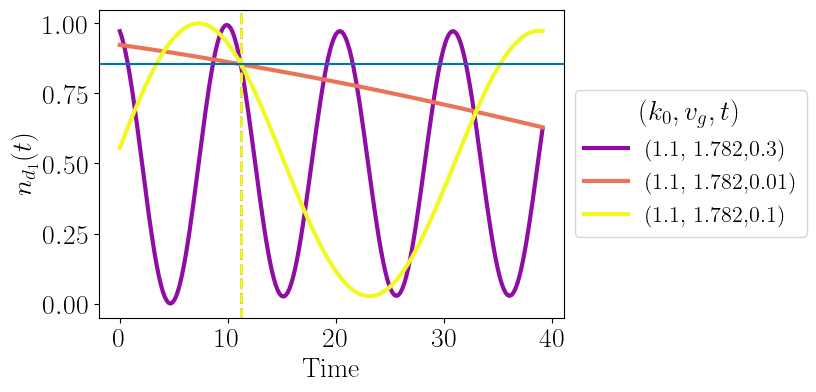

In [5]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name)  
  
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(param_dict["K0"])
    tau_to_bond = (param_dict["bond_index"]-param_dict["X0"])/vg
    
    lab = "("+str(round(param_dict["K0"],3)) + ", " + str(round(vg,3))+ "," +str(param_dict["t"]) + ")" 
    
    plt.plot(times, d0_density, linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)
    
plt.axhline(np.cos(0.785/2)**2)
plt.legend(title=r"$(k_0, v_g, t)$",loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")



# Generating Analysis dataframe

Here we put all the processed and raw data in a dataframe for convenient reading abd analysis

In [6]:
file_list = get_file_names_on([], data_route)
file_list


['exact_L100_J1.0_t0.001_om0.3_Del7.0_xo30_k0.4712_bindex50_maxtau90.000_tstep0.180_alpha1.000_beta0.000_phi0.0_alpha_bond0.000_qinitfixed.h5',
 'exact_L100_J1.0_t0.0001_om0.6_Del7.0_xo30_k1.3352_bindex50_maxtau90.000_tstep0.180_alpha0.854_beta0.146_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t5.0_om1.0_Del7.0_xo30_k1.3352_bindex50_maxtau90.000_tstep0.180_alpha0.163_beta0.837_phi0.0_alpha_bond0.000_qinitfixed.h5',
 'exact_L100_J1.0_t2.0_om0.3_Del7.0_xo30_k1.3352_bindex50_maxtau90.000_tstep0.180_alpha0.354_beta0.646_phi0.0_alpha_bond1.571_qinitfixed.h5',
 'exact_L100_J1.0_t0.5_om0.1_Del7.0_xo30_k0.7854_bindex50_maxtau90.000_tstep0.180_alpha0.852_beta0.148_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t0.4_om0.1_Del7.0_xo30_k1.5708_bindex50_maxtau90.000_tstep0.180_alpha0.427_beta0.573_phi0.0_alpha_bond0.000_qinitfixed.h5',
 'exact_L100_J1.0_t0.4_om0.6_Del7.0_xo30_k1.4137_bindex50_maxtau90.000_tstep0.180_alpha0.985_beta0.015_phi0.0_alpha_bond1.571_qinitfixed.h5',
 

In [81]:
# read the parameter dictionary to initialize 
param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_list[0])  

data_dict =  {key: [] for key in param_dict}
data_dict["times"] = []
data_dict["occupations"] = []
data_dict["d0_density"] = []
data_dict["qubit_rho"] = []
data_dict["entropy"] = []
data_dict["time_at_bond"] = []
data_dict["Max_entropy"] = []
data_dict["cos_theta"] = []
data_dict["sin_phi"] = []

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name) 
    # initialize the meta data
    for key in param_dict.keys():
        data_dict[key].append(param_dict[key])

    #  estimate the time that wavepacket spends at bondf
    bond_density = occupations[param_dict["bond_index"], :] + occupations[param_dict["bond_index"]+1, :]
    tau_bond = get_time_at_bond(times, bond_density)
    
    # get the bloch angles fo the qubit
    costheta_list, sinphi_list = get_bloch_angles_time(qubit_rho)

    # save raw data 
    data_dict["times"].append(list(times.astype(np.float32)))
    data_dict["occupations"].append(occupations.astype(np.float32))
    data_dict["d0_density"].append(d0_density.astype(np.float32)) 
    data_dict["qubit_rho"].append(qubit_rho.astype(np.complex64))
    # normalize entropy by maximally entangled singled 
    data_dict["entropy"].append(list((entropy/np.log(2)).astype(np.float32)))
    # save processed data
    data_dict["time_at_bond"].append(tau_bond)
    data_dict["Max_entropy"].append(max(entropy/np.log(2)))
    data_dict["cos_theta"].append(costheta_list)
    data_dict["sin_phi"].append(sinphi_list)

data_df = pd.DataFrame.from_dict(data_dict)

data_df.to_csv("../../data/exp_pro/exact_diag_L={}.csv".format(ll))

# Phase diagram

In [82]:
Om_ = 0.3 
X0_ = 30

af = data_df["alfabond"].sort_values().unique()[2]
print(np.cos(af/2)**2)
data_df["alfabond"].sort_values().unique()
data_df["X0"].unique()

0.8535533905932737


array([30])

In [83]:

print(np.cos(af/2)**2)
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_)  & (data_df["qubit_init"]=="fixed") & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)

data_S = data_df[cond_].sort_values(by="K0")

S_df = data_S.pivot(index='K0', columns='t', values='Max_entropy')
S_df

0.8535533905932737


t,0.0001,0.0010,0.0100,0.0200,0.0300,0.0400,0.0500,0.0600,0.0700,0.0800,...,0.3000,0.4000,0.5000,0.7000,0.8000,0.9000,1.0000,2.0000,3.0000,5.0000
K0,,,,,,,,,,,,,,,,,,,,,
0.471239,0.309272,0.313448,0.358923,0.397346,0.415030,0.420994,0.421851,0.419125,0.414626,0.408047,...,0.171824,0.158083,0.147135,0.124902,0.121770,0.110621,0.104378,0.006880,0.001878,0.000662
0.628319,0.233867,0.235436,0.252477,0.271226,0.286672,0.297947,0.305649,0.310815,0.314348,0.316801,...,0.152630,0.125774,0.115973,0.101219,0.095341,0.089756,0.084894,0.006191,0.001811,0.000657
0.785398,0.185104,0.185808,0.193358,0.202168,0.210569,0.217972,0.224129,0.229086,0.233077,0.236418,...,0.209323,0.128582,0.096317,0.084120,0.079781,0.075964,0.072591,0.005838,0.001783,0.000650
0.942478,0.154008,0.154389,0.158408,0.163117,0.167798,0.172209,0.176179,0.179618,0.182514,0.184920,...,0.221081,0.186037,0.118629,0.073163,0.070060,0.067749,0.065987,0.005607,0.001904,0.000698
1.099557,0.134203,0.134445,0.136950,0.139846,0.142740,0.145525,0.148108,0.150426,0.152442,0.154144,...,0.175991,0.187637,0.174001,0.080741,0.066310,0.064982,0.065176,0.005033,0.001936,0.000770
1.178097,0.127307,0.127510,0.129597,0.131987,0.134368,0.136662,0.138802,0.140735,0.142429,0.143867,...,0.157609,0.168430,0.175879,0.103609,0.073226,0.066096,0.067480,0.005212,0.002056,0.000703
1.256637,0.121996,0.122172,0.123971,0.126012,0.128035,0.129981,0.131798,0.133444,0.134890,0.136120,...,0.143940,0.151515,0.162982,0.133923,0.093441,0.073527,0.072435,0.004905,0.001878,0.000771
1.335177,0.118058,0.118216,0.119821,0.121624,0.123402,0.125107,0.126696,0.128136,0.129401,0.130475,...,0.134193,0.139294,0.148069,0.154693,0.122719,0.092119,0.081768,0.005066,0.002078,0.000718
1.413717,0.115345,0.115491,0.116969,0.118620,0.120239,0.121785,0.123224,0.124526,0.125667,0.126633,...,0.127684,0.131183,0.137463,0.159418,0.149947,0.121112,0.096611,0.004876,0.001984,0.000783


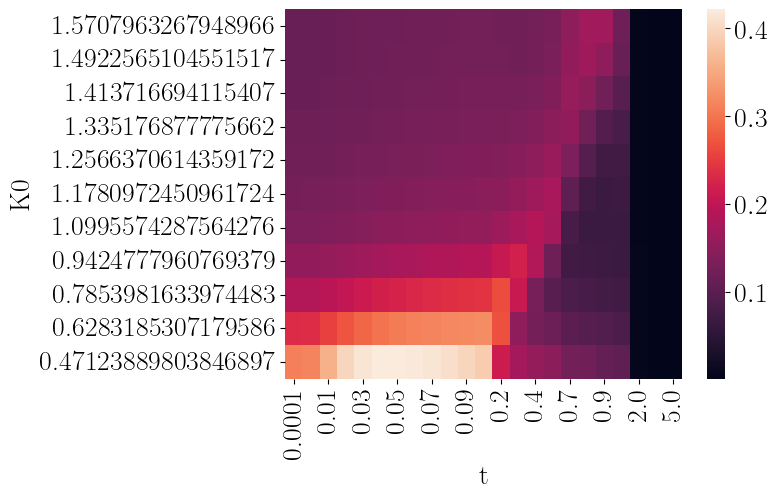

In [84]:
fig, ax = plt.subplots(1,1)
sns.heatmap(S_df)
ax.invert_yaxis()

In [85]:
print(data_df["L_qpc"].unique())
LL = data_df["L_qpc"].unique()[0]
J = data_df["J"].unique()[0]


[100]


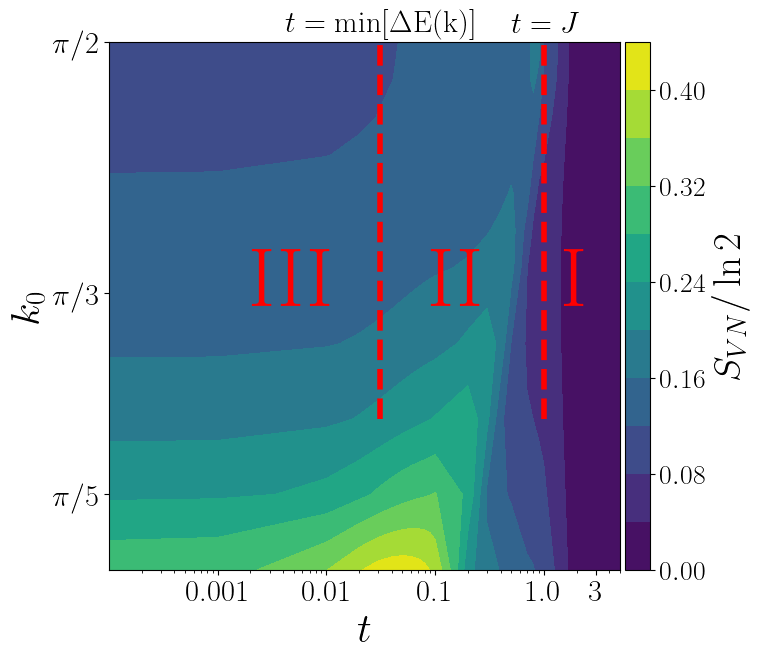

In [86]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(t_array, vg_array, S_df.values,levels=10)

plt.xscale('log')

# Add anotate the regions
y_tick = np.pi/2 -0.04
ax.annotate(
    r'$t=\rm{min}[ \Delta E(k)]$', 
    xy=(np.pi/(LL+1), y_tick), 
    xytext=(np.pi/(LL+1), y_tick + 0.06), fontsize=22,ha='center')
ax.annotate(
    r'$t=J$', 
    xy=(J, y_tick), 
    xytext=(J, y_tick + 0.06), fontsize=22,ha='center')

# Add the labels for each region
ax.annotate('II', xy=(0.1+np.pi/50, 0.65*np.pi/2), 
            xytext=(0.1+np.pi/50, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('III', xy=(0.005, 0.65*np.pi/2), 
            xytext=(0.005, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('I', xy=(2.0, 0.65*np.pi/2), 
            xytext=(2.0, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.vlines([np.pi/(LL+1), J], ymin=0.5*np.pi/2, ymax=np.pi/2, color='red', lw=4, linestyle="dashed", clip_on=False)  # tick-like line

ax.set_xticks( [0.001, 0.01,0.1,1.0,3], [0.001, 0.01,0.1,1.0,3] ,fontsize=22)
ax.set_yticks( [np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"],fontsize=22 )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}/\ln{2}$', rotation=90, fontsize=28)

ax.set_ylabel(r"$k_0$",fontweight='bold',fontsize=30)
ax.set_xlabel(r"$t$",fontweight='bold',fontsize=30)

plt.tight_layout()

# plt.savefig(fig_route+"entropy_phase_diagram_new.pdf",transparent=True)

## Now the same for the backaciton

what if I take the difference at each point in time and then I average or something

In [216]:
dict_phi = {"dsin": [],"dsin_avg": []}
window = 10 # for rolling avg

for i in range(0,len(data_S)):
    sinphi = np.real(data_S.iloc[i]["sin_phi"])
    del_sinphi_list = []
    for ti in range(0,len(sinphi)):
        del_sinphi_list.append(np.abs( (sinphi[0]- np.abs(sinphi[ti]))/sinphi[0]))
        
    # test a rolling avg
    rolling_avg = np.convolve(del_sinphi_list, np.ones(window)/window, mode='valid')
        
    dict_phi["dsin"].append(del_sinphi_list)
    dict_phi["dsin_avg"].append(rolling_avg)

data_S["dsinphi_t"] = dict_phi["dsin"]
data_S["dsinphi_avg"] = dict_phi["dsin_avg"]

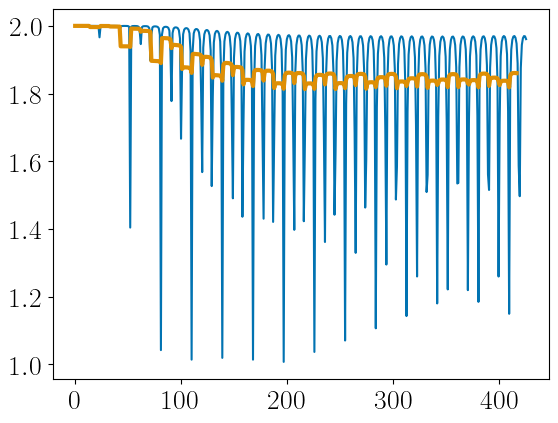

In [221]:
plt.plot(data_S.iloc[0]["dsinphi_t"])
plt.plot(data_S.iloc[0]["dsinphi_avg"], linewidth=3)


given this structure lets average over the last 100 entries

In [222]:
data_S["Delta_phi"] = data_S["dsinphi_avg"].apply(lambda x: x[-1])


In [223]:
Phi_df = data_S.pivot(index='K0', columns='t', values='Delta_phi')
Phi_df

t,0.0001,0.0010,0.0100,0.0200,0.0300,0.0400,0.0500,0.0600,0.0700,0.0800,...,0.3000,0.4000,0.5000,0.7000,0.8000,0.9000,1.0000,2.0000,3.0000,5.0000
K0,,,,,,,,,,,,,,,,,,,,,
0.471239,0.362128,0.316874,0.202178,1.397350,1.632146,1.744254,1.123999,1.735000,1.751423,1.138273,...,0.067739,0.367713,1.936295,0.171818,1.810012,1.860320,0.141495,0.010018,0.000749,0.002757
0.628319,0.238015,0.212087,0.125692,0.218833,1.053820,1.774888,1.841360,1.639518,1.403446,1.820627,...,1.808188,1.713693,0.045533,0.164112,1.849501,0.155905,1.873076,0.078310,1.990371,0.000856
0.785398,0.162866,0.147078,0.086273,0.110686,1.622272,1.542793,1.868343,1.897015,1.806792,1.156145,...,1.717954,0.305621,1.790900,1.947241,1.877317,0.106453,1.895156,0.001901,1.999771,1.999778
0.942478,0.117345,0.106953,0.063239,0.069487,0.161912,1.097910,1.816870,1.920823,1.926386,1.859549,...,1.494966,1.637894,0.225628,0.081499,1.938126,1.899525,0.103229,0.000864,0.000402,0.000136
1.099557,0.089464,0.082082,0.049108,0.049478,0.091263,1.569262,1.678402,1.915381,1.946993,1.940029,...,0.063955,1.659572,0.300780,1.872903,0.126687,1.906310,1.808252,1.999821,0.000029,0.000046
1.178097,0.079977,0.073566,0.044269,0.043328,0.073853,1.703146,1.557143,1.907063,1.950085,1.951879,...,0.148998,1.649549,0.075692,1.814328,0.070588,0.100035,1.890759,0.001302,1.999980,1.999986
1.256637,0.072750,0.067048,0.040535,0.038875,0.062705,1.777391,1.417990,1.897830,1.951511,1.958242,...,0.391660,1.901984,0.153050,1.920833,0.165295,0.139136,1.898213,0.000139,0.006518,0.000022
1.335177,0.067438,0.062225,0.037731,0.035740,0.055765,1.816508,1.302442,1.891089,1.952570,1.961935,...,0.402115,1.949401,0.283390,1.801546,1.832972,0.169946,1.869332,1.999891,0.000015,1.999992
1.413717,0.063807,0.058964,0.035906,0.033541,0.050363,1.849082,1.187969,1.876187,1.951421,1.964035,...,0.337046,1.951841,1.719408,1.767573,1.817877,0.170635,1.863799,1.998783,0.000112,0.000011


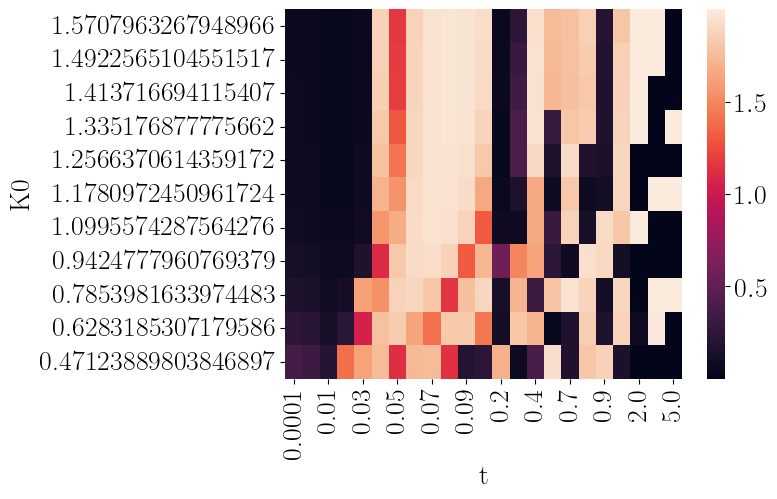

In [224]:
fig, ax = plt.subplots(1,1)
sns.heatmap(Phi_df)
ax.invert_yaxis()

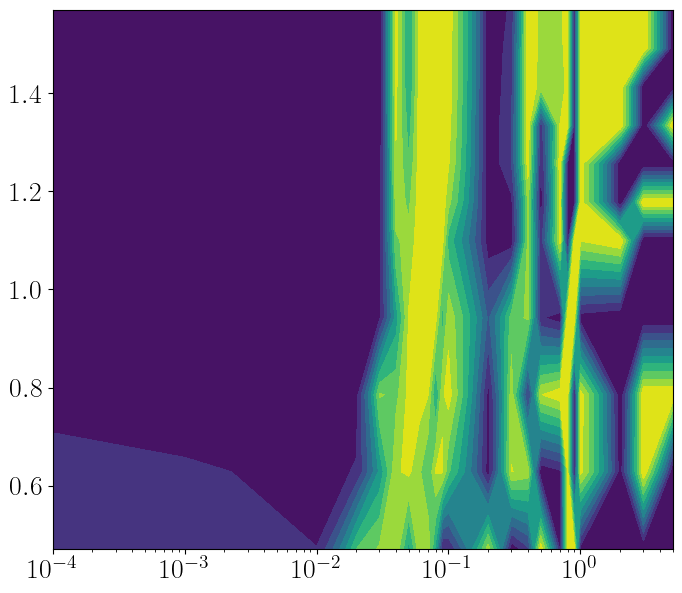

In [225]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

y_vals = Phi_df.index
x_vals = Phi_df.columns
im = ax.contourf(x_vals, y_vals, Phi_df.values,levels=10)

plt.xscale('log')

# Entropy Production

I need to compare this directly to perturbation theory

In [127]:
t_ = 0.1

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)  & (data_df["X0"]==X0_)  & (data_df["alfabond"]==af)
curr_df = data_df[cond_].sort_values(by="K0")


## As a function of time for fixed $t$

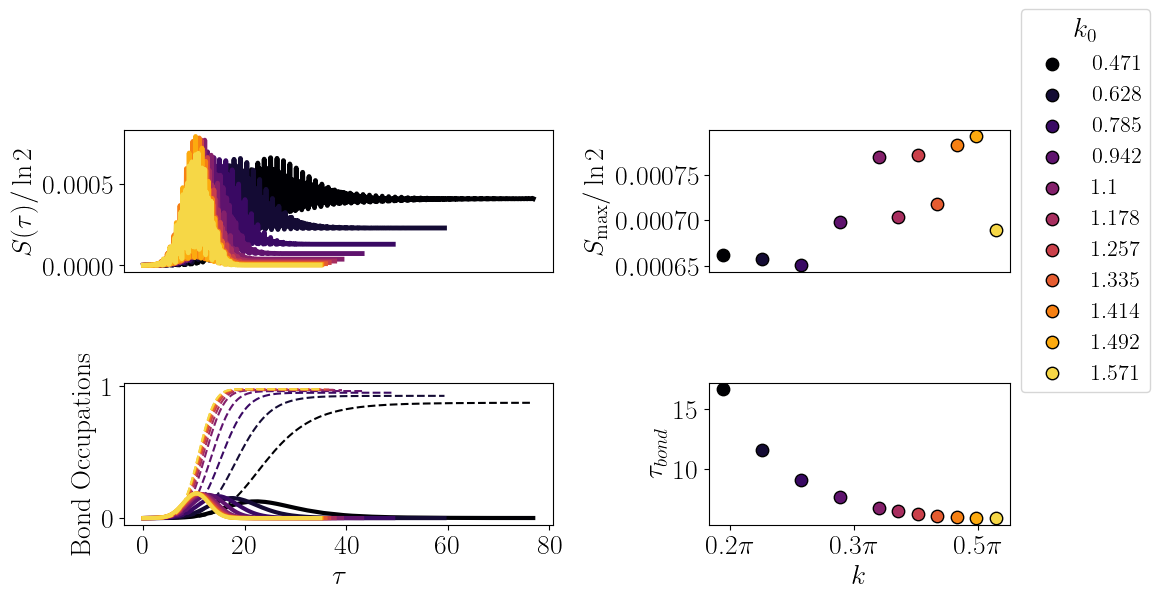

In [128]:
# Create 2x2 sub plots

fig = plt.figure(figsize=(12,6))

#plt.suptitle(om_s + ", " + bw_s + ", " + t_s )
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.7])
K0_unique = curr_df["K0"].unique()
colors = plt.cm.inferno(np.linspace(0.0,0.9,len(K0_unique)))

for i in range(0,len(K0_unique)):
    # generate the legend
    lab = str(round(K0_unique[i],3))
    # Entropy in time
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    xvals = curr_df[curr_df["K0"]== K0_unique[i]]["times"].item()
    yvals = curr_df[curr_df["K0"]== K0_unique[i]]["entropy"].item()
    ax.plot(xvals,yvals, linewidth=3.5, c=colors[i])
    
    # max entropy
    ax = plt.subplot(gs[0, 1])
    ax.scatter(K0_unique[i], max(yvals), c=[colors[i]], s=80, edgecolor='black', zorder=7,label=lab)
    
    # plot density at the bond in time and transmission
    bindex = curr_df[curr_df["K0"]== K0_unique[i]]["bond_index"].item()
    occ_matrix = curr_df[curr_df["K0"]== K0_unique[i]]["occupations"].item()
    bond_density = occ_matrix[bindex, :] + occ_matrix[bindex+1, :] 
    transmission = np.sum(occ_matrix[bindex+2:,:], axis=0)
    
    ax = plt.subplot(gs[1, 0]) # row 1, col 0
    ax.plot(xvals,bond_density, linewidth=3, c=colors[i])    
    ax.plot(xvals, transmission, linestyle="dashed", linewidth=1.5, c=colors[i])
    # plot time spent at bond
    ax = plt.subplot(gs[1, 1]) # row 1, col 1
    ax.scatter(K0_unique[i], curr_df[curr_df["K0"]== K0_unique[i]]["time_at_bond"], c=[colors[i]], s=80, edgecolor='black', zorder=7)


# Set up labels and legends
plt.subplot(gs[0, 0]).set_ylabel(r"$S(\tau)/\ln{2}$")
plt.subplot(gs[0, 0]).set_xticks([])

plt.subplot(gs[0, 1]).set_xticks([])
plt.subplot(gs[0, 1]).set_ylabel(r"$S_{\rm{max}}/\ln{2}$")
# plt.subplot(gs[0, 1]).legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(gs[1, 0]).set_ylabel(r"Bond Occupations")
plt.subplot(gs[1, 0]).set_xlabel(r"$\tau$")

plt.subplot(gs[1, 1]).set_ylabel(r"$\tau_{bond}$")
plt.subplot(gs[1, 1]).set_xlabel(r"$k$")
# write x axis in units of pi
plt.subplot(gs[1, 1]).xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.subplots_adjust(wspace=0.16, hspace=0.09)

plt.tight_layout()

## Maximum entropy as a function of $t$ for fixed $k_0$

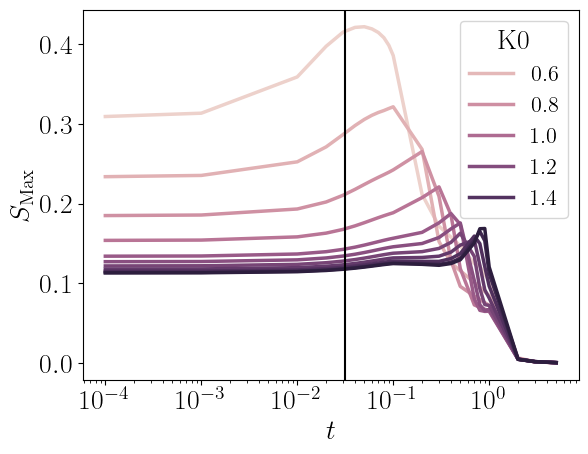

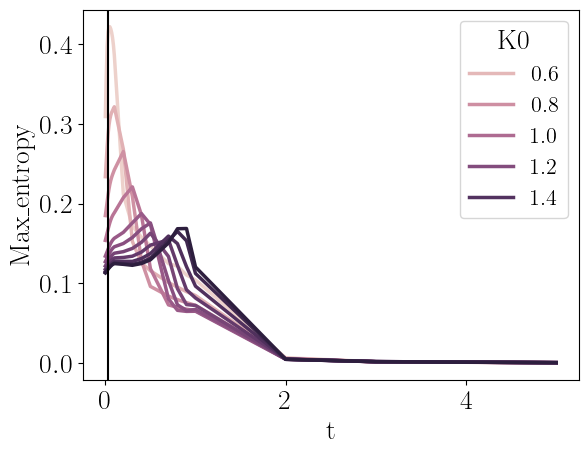

In [129]:

cond_ = (data_df["Omega"]==Om_)  & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)
curr_df = data_df[cond_]

plt.figure()
sns.lineplot(data=curr_df, x="t", y="Max_entropy", hue="K0", linewidth=2.5)
plt.axvline(np.pi/(ll+1), c= "black")
plt.xscale('log')
plt.ylabel(r"$S_{\rm{Max}}$")
plt.xlabel(r"$t$")


plt.figure()
sns.lineplot(data=curr_df, x="t", y="Max_entropy", hue="K0", linewidth=2.5)
plt.axvline(np.pi/(ll+1), c= "black")


## Maximum entropy as a function of occupation at bond when hit for fixed $k_0$ and $t$

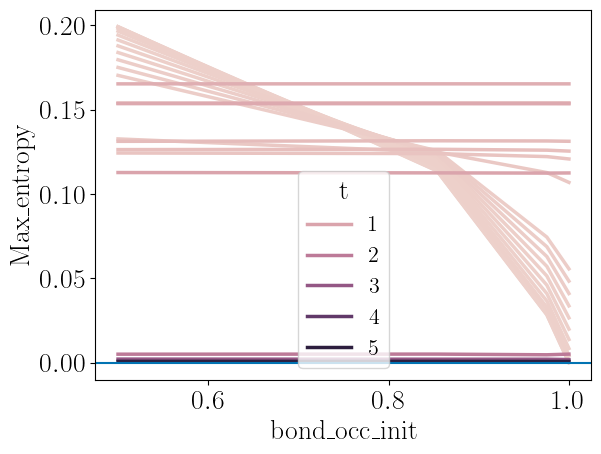

In [132]:
cond_ = (data_df["Omega"]==Om_)  & (data_df["X0"]==X0_) & (data_df["K0"]==np.sort(data_df["K0"].unique())[-2]) 
curr_df = data_df[cond_].copy()
curr_df["bond_occ_init"] = np.cos(curr_df["alfabond"]*0.5)**2
plt.figure()
sns.lineplot(data=curr_df, x="bond_occ_init", y="Max_entropy", hue="t", linewidth=2.5)
plt.axhline(0)


# Maximum Entropy as a function of the qubit occupation

In [133]:
# Do a grid of phase diagrams
# also test wheterh my hypothesis regarding regarding regime III only depending on density is correct

# Single cases

In [134]:
k0_list = np.sort(data_df["K0"].unique())
print(k0_list)
k0_ = k0_list[-1]
print(Om_, t_, k0_,X0_)

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_) & (data_df["K0"]==k0_)  & (data_df["X0"]==X0_) &  (data_df["alfabond"]==af)
curr_df = data_df[cond_]


[0.4712389  0.62831853 0.78539816 0.9424778  1.09955743 1.17809725
 1.25663706 1.33517688 1.41371669 1.49225651 1.57079633]
0.3 5 1.5707963267948966 30


## Wavefunction

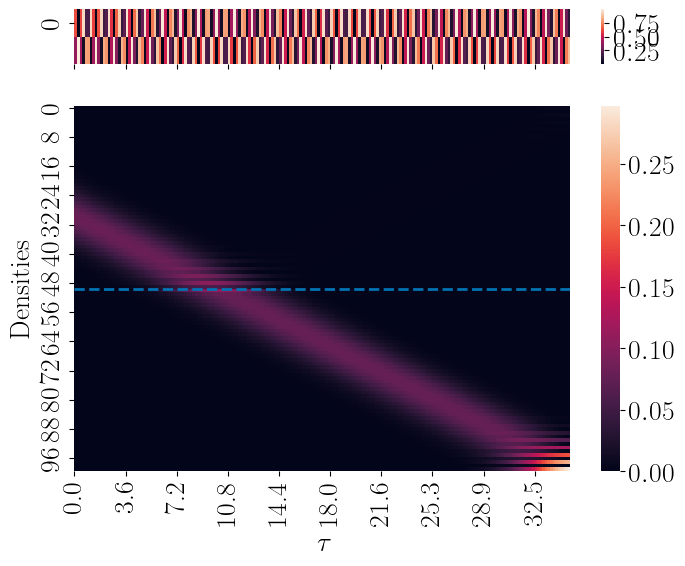

In [135]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
n_d1 = curr_df["d0_density"].item()
sns.heatmap([n_d1,1-n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")

ax[1].set_ylabel("Densities")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);


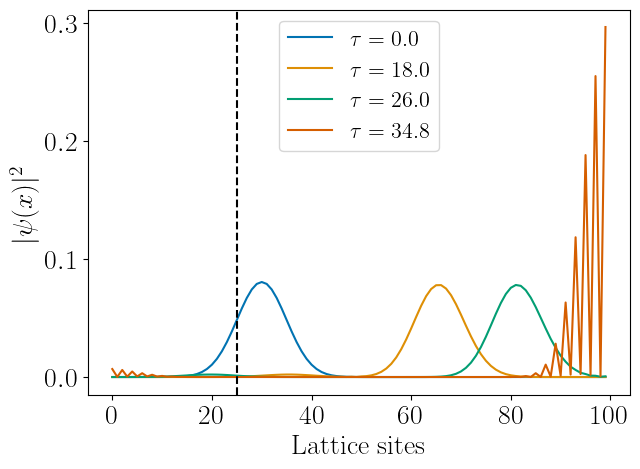

In [136]:
fig, ax = plt.subplots(1,1,figsize=(bwidth,bheight))

plt.plot(traj_matrix[:,0], label=r"$\tau={:.3}$".format(time_range[0]))
plt.plot(traj_matrix[:,100], label=r"$\tau={:.3}$".format(time_range[100]))
plt.plot(traj_matrix[:,-50], label=r"$\tau={:.3}$".format(time_range[-50]))
plt.plot(traj_matrix[:,-1], label=r"$\tau={:.3}$".format(time_range[-1]))
plt.axvline(25, c="black", linestyle="dashed")
plt.xlabel("Lattice sites")
plt.ylabel(r"$|\psi (x)|^2$")
plt.legend()

## Bloch Sphere

In [137]:
costheta = curr_df["cos_theta"].item()
sinphi = curr_df["sin_phi"].item()
time_range = curr_df["times"].item()
bindex = curr_df["bond_index"].item()
ϕ0 = curr_df["phi"].item()
rhot = curr_df["qubit_rho"].item()

τbond = X0_ - bindex/(2*J*np.sin(k0_))
cosθ0 = costheta[0]

data_df.columns


Index(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread',
       'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0',
       'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond', 'times', 'occupations',
       'd0_density', 'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy',
       'cos_theta', 'sin_phi'],
      dtype='object')

In [138]:
rho_free_list = [rhot[0]]
theta_free_list = [np.arccos(np.real(cosθ0))]
phi_free_list = [ϕ0]

# calculate the free qubit bloch angles as a funciton of time
# by using the rotaiton matrix of the free dynamics

for i in range(1,len(time_range)):
    # rotate up to time tau
    τ = time_range[i] 
    rho_tau = rotate_rho(rho_free_list[0], τ, t_ , ϕ0)
    # get the angles at that tau
    Cos_theta_p, Sin_phi_p = get_bloch_angles(rho_tau)
    
    rho_free_list.append(rho_tau)
    theta_free_list.append(np.arccos(Cos_theta_p))
    phi_free_list.append(np.arcsin(Sin_phi_p))


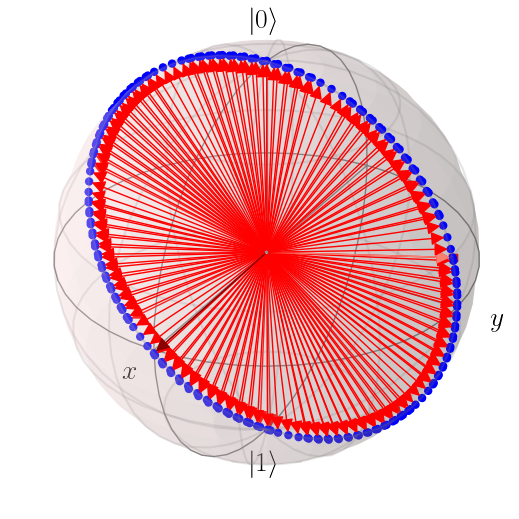

In [139]:
# Now plot the numerical coupled case
dd_theta = np.arccos(costheta)
dd_phi = np.arcsin(sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*sinphi
z_ = np.asarray(costheta)

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

# writting out free case solution in spherical coordinates
x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
z_free = np.cos(theta_free_list)

free_points = [x_, y_, z_]
free_first= [x_[0], y_[0], z_[0]] # first point for different color

bs = Bloch()

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color
bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])
bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]
bs.vector_width = 1.0

# now add the free vectors
bs.add_points(free_points)
bs.add_points(free_first)

#bs.view = [-20, 30]  

bs.show()

Text(0.5, 0, '$\\tau$')

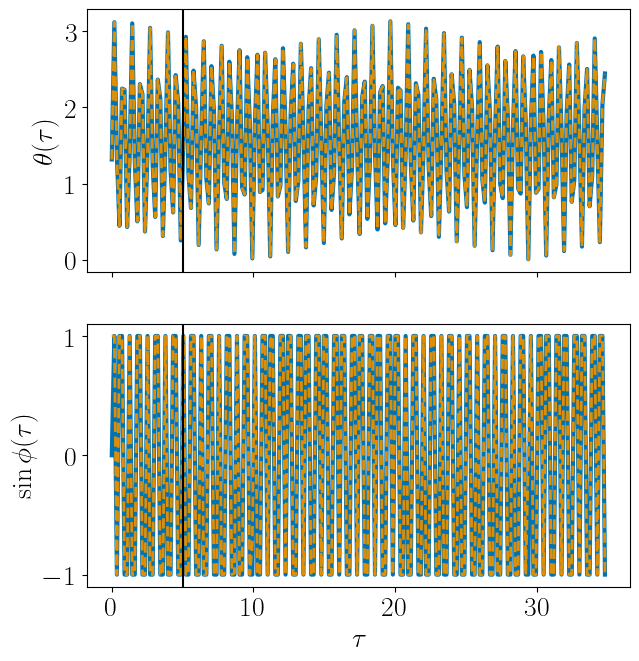

In [140]:
fig, ax = plt.subplots(2,1,figsize=(bwidth,1.5*bheight), sharex = True)

ax[0].plot(time_range, np.real(theta_free_list), linewidth=3)
ax[0].plot(time_range, np.real(dd_theta), linewidth=2.0, linestyle="dashed")
ax[0].axvline(τbond, c="black")

ax[1].plot(time_range, np.real(np.sin(phi_free_list)), linewidth=3 )
ax[1].plot(time_range, np.real(sinphi),linewidth=2.0, linestyle="dashed")
ax[1].axvline(τbond,c="black")

ax[0].set_ylabel(r"$\theta (\tau)$")
ax[1].set_ylabel(r"$\sin\phi (\tau)$")
ax[1].set_xlabel(r"$\tau$")

# Comparing with Qutip (smaller system)

In [64]:
print(K0_unique)
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)  & (data_df["X0"]==11)
curr_df = data_df[cond_].sort_values(by="K0")


[0.4712389  0.62831853 0.78539816 0.9424778  1.09955743 1.17809725
 1.25663706 1.33517688 1.41371669 1.49225651 1.57079633]


In [65]:
drold = '../../data/sims/L=21/'
file_listold = get_file_names_on(["om{}_".format(Om_), "k1.5708","t{}".format(t_),"bw2.0"], drold)
file_name = file_listold[0]
param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(drold,file_name)
τb  = param_dict["bond_index"]/(2 * J * np.sin(param_dict["k0"]))

file_listold

['res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.1_om0.3_dd0fixed.hdf5']

In [30]:

xvals = curr_df[curr_df["K0"]== K0_unique[-1]]["times"].item()
yvals = curr_df[curr_df["K0"]== K0_unique[-1]]["entropy"].item()

times_coarse = np.linspace(times[0], times[-1], len(VN_entropy))

plt.plot(times_coarse, VN_entropy/np.log(2))
plt.plot(xvals, curr_df[curr_df["K0"]==K0_unique[-1]]["entropy"].item() , linestyle="dashed")

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
data_full_df = pd.read_csv('../../data/exp_pro/exploration_data_L=21.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()
data_full_df["Max_entropy_norm"] = data_full_df["max_VN_entropy"]/np.log(2)

In [ ]:
hop_list = [0.01, 0.1, 0.3, 0.4,0.5,1.0]

In [ ]:
cond_old =  (data_full_df["x_spread"] == 2.0) & (data_full_df["Omega"] == Om_) & (data_full_df["t"].isin(hop_list))
cond_ = (data_df["Omega"]==Om_) & (data_df["K0"]>0.1)  & (data_df["qubit_init"]=="fixed") & (data_df["t"].isin(hop_list))
print(data_full_df[cond_old]["t"].unique())
print(data_df[cond_]["t"].unique())

In [ ]:
# odl data
sns.scatterplot(data= data_full_df[cond_old], x = "k0", y="Max_entropy_norm", s = 90, marker="X", hue="t")
sns.scatterplot(data= data_df[cond_], x = "K0", y="Max_entropy", s = 70, marker="o",hue="t")

plt.legend(
    title=r"$t$",
    bbox_to_anchor=(1.05, 1),  # position legend outside to the right
    loc='upper left',
    borderaxespad=0
)